## XAI Programming Asignment I: **Shap on OPTUNA** 

The goal is to run hyperparameter optimization algorithm such as optuna, collect results from it and use SHAP to try to explain the impact of different hyperparameters on the quality of the optimization process.

## OPTUNA - Przepotężny tuńczyk

In [1]:
import optuna
import shap
import xgboost as xgb
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
def save_results(results_df, filename, directory="optuna_results"):
    os.makedirs(directory, exist_ok=True)
    results_df.to_csv(f"{directory}/{filename}.csv", index=False)

In [3]:
def load_results(filename, directory="optuna_results"):
    results_df = pd.read_csv(f"{directory}/{filename}.csv")
    return results_df

#### **RandomForestClassifier optimization performed on the Adult dataset**


In [8]:
X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
parameters = [
    "n_estimators",
    "max_depth",
    "min_samples_split",
    "min_samples_leaf",
    "max_features",
    "criterion",
    "class_weight"
]

In [9]:
def objective_randomforest(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 10000)
    max_depth = trial.suggest_int("max_depth", 5, 1000)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 1000)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 500)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        class_weight=class_weight
    )
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="f1", n_jobs=-1).mean()
    return score

The dataset is imalanced so we maximize F1-score.

In [10]:
study = optuna.create_study(direction="maximize")

[I 2025-01-08 21:06:45,899] A new study created in memory with name: no-name-e528cece-3759-40cf-81a7-b4d6259ea797


In [11]:
study.optimize(objective_randomforest, n_trials=500, n_jobs=-1)

[I 2025-01-08 21:07:04,005] Trial 5 finished with value: 0.5758423396556499 and parameters: {'n_estimators': 1898, 'max_depth': 364, 'min_samples_split': 998, 'min_samples_leaf': 319, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': None}. Best is trial 5 with value: 0.5758423396556499.
[I 2025-01-08 21:07:13,693] Trial 4 finished with value: 0.6214062299945151 and parameters: {'n_estimators': 3713, 'max_depth': 873, 'min_samples_split': 659, 'min_samples_leaf': 451, 'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.6214062299945151.
[I 2025-01-08 21:07:15,562] Trial 7 finished with value: 0.6297341011273048 and parameters: {'n_estimators': 3239, 'max_depth': 942, 'min_samples_split': 249, 'min_samples_leaf': 98, 'max_features': 'log2', 'criterion': 'entropy', 'class_weight': None}. Best is trial 7 with value: 0.6297341011273048.
[I 2025-01-08 21:07:24,049] Trial 18 finished with value: 0.5941002496537355 and parameters:

In [41]:
print("Best hyperparameters:", study.best_params)
print("Best f1_score:", study.best_value)

Best hyperparameters: {'n_estimators': 5016, 'max_depth': 641, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced'}
Best f1_score: 0.7066157257483057


In [42]:
results_df = study.trials_dataframe()

In [43]:
save_results(results_df, 'random_forest_adult')

In [49]:
best_params_df = pd.DataFrame([study.best_params])

In [50]:
save_results(best_params_df, filename='random_forest_adult_best_params', directory="optuna_results")

In [44]:
optuna.visualization.plot_optimization_history(study)

In [45]:
optuna.visualization.plot_edf(study)

In [46]:
optuna.visualization.plot_param_importances(study)

In [47]:
for param in parameters:
    fig = optuna.visualization.plot_slice(study, params=[param])
    fig.update_layout(
        title=f"Slice Plot for {param}",
        yaxis_title="Objective Value",
        xaxis_title=param
    )

    pio.show(fig)

#### **Shap values - RandomForestClassifier optimization on Adult dataset**
To compare results and improve reliability of SHAP explanations, we take 3 models to approximate hyperparameter impact. 
* RandomForestRegressor
* XGBoostRegressor
* MLPRegressor

Models are trained on the output from optimization process on Adult dataset. They are tuned with Optuna as well.

In [6]:
results_df = load_results('random_forest_adult')

In [7]:
X_shap = results_df[[
    "params_n_estimators", 
    "params_max_depth", 
    "params_min_samples_split", 
    "params_min_samples_leaf", 
    "params_max_features", 
    "params_criterion", 
    "params_class_weight"
]]

y_shap = results_df["value"]

categorical_columns = ["params_max_features", "params_criterion", "params_class_weight"]

In [8]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(X_shap[categorical_columns])
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
encoded_features_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X_shap.index)

X_shap_encoded = pd.concat(
    [X_shap.drop(columns=categorical_columns), encoded_features_df],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(X_shap_encoded, y_shap, test_size=0.2)

##### RandomForestRegressor

In [23]:
def objective_random_forest_adult_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 100)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        bootstrap=bootstrap
    )
    
    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1
    ).mean()
    
    return score

It's a regression problem - we minimize Mean Absolute Error (MAE).

In [24]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest_adult_random_forest, n_trials=200, n_jobs=-1)

[I 2025-01-09 13:38:38,954] A new study created in memory with name: no-name-ff1fb974-7127-4a97-b161-e623868f3c13
[I 2025-01-09 13:38:40,492] Trial 0 finished with value: 0.006600336997398387 and parameters: {'n_estimators': 358, 'max_depth': 84, 'max_features': 0.6821941871300614, 'min_samples_leaf': 17, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 0 with value: 0.006600336997398387.
[I 2025-01-09 13:38:40,613] Trial 1 finished with value: 0.006695949886778431 and parameters: {'n_estimators': 333, 'max_depth': 31, 'max_features': 0.5260162226461135, 'min_samples_leaf': 11, 'min_samples_split': 13, 'bootstrap': True}. Best is trial 0 with value: 0.006600336997398387.
[I 2025-01-09 13:38:40,658] Trial 2 finished with value: 0.00654465942903219 and parameters: {'n_estimators': 424, 'max_depth': 76, 'max_features': 0.9968031766796723, 'min_samples_leaf': 12, 'min_samples_split': 16, 'bootstrap': True}. Best is trial 2 with value: 0.00654465942903219.
[I 2025-01-09 13:38:40,8

In [26]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.0020171756185724792
Params: {'n_estimators': 534, 'max_depth': 52, 'max_features': 0.859106244552438, 'min_samples_leaf': 1, 'min_samples_split': 4, 'bootstrap': False}


In [33]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='random_forest_best_params', directory='random_forest_adult_models')

In [9]:
best_params_df = load_results(filename='random_forest_best_params', directory='random_forest_adult_models')

In [10]:
model = RandomForestRegressor(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    bootstrap=bool(best_params_df['bootstrap'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0]
)

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=52,
                      max_features=0.859106244552438, min_samples_split=4,
                      n_estimators=534)

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

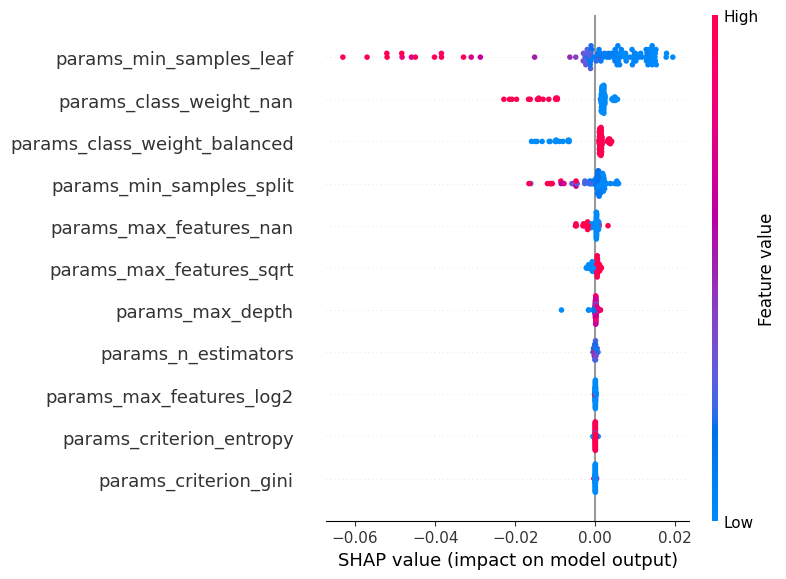

In [46]:
shap.summary_plot(shap_values, X_test)

Optuna focuses on values that provide the best model performance so most instances have SHAP values greater than or equal to 0.

Better performance can be achieved when:
* *min_samples_leaf* has lower values 
* *class_weight* value equals 'balanced'
* *min_samples_split* has lower values 
* *max_features* equals 'sqrt'

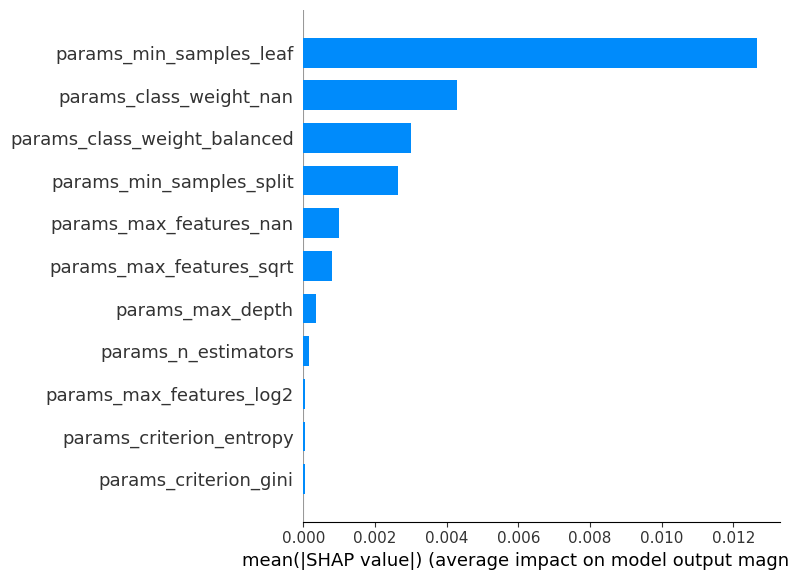

In [47]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* min_samples_leaf
* class_weight
* min_samples_split

Least important features: 
* criterion
* max_features = 'log2'
* n_estimators

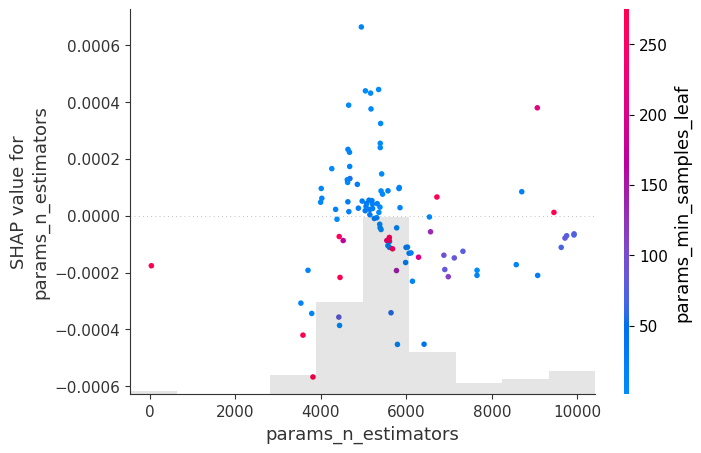

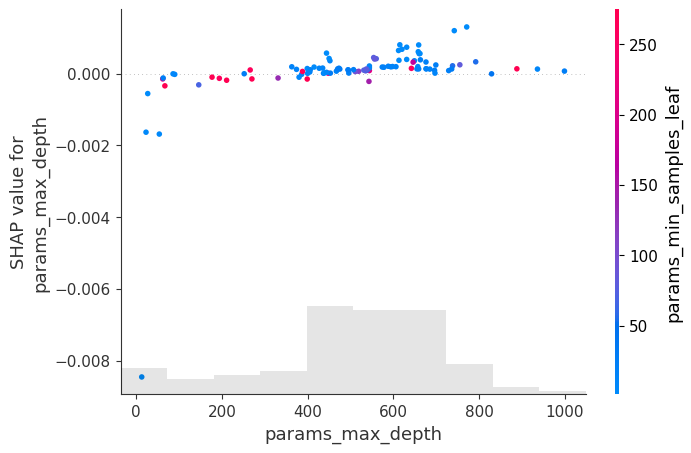

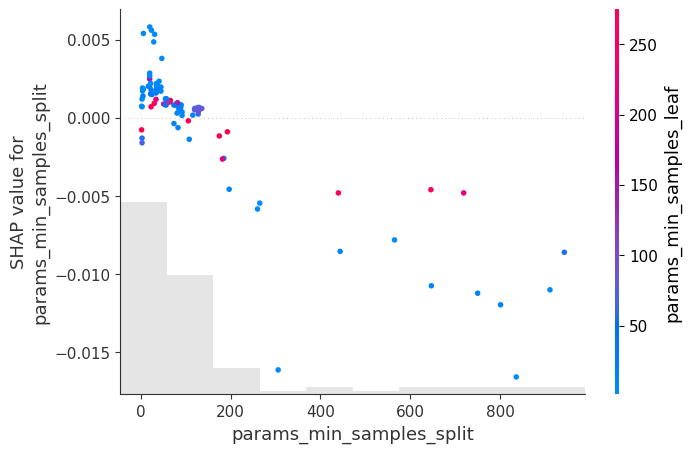

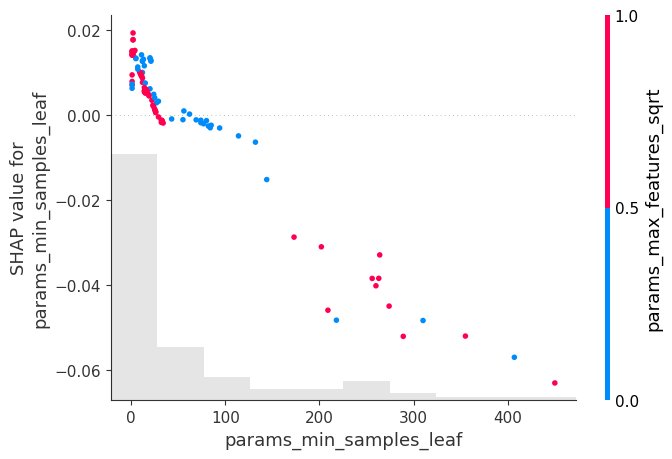

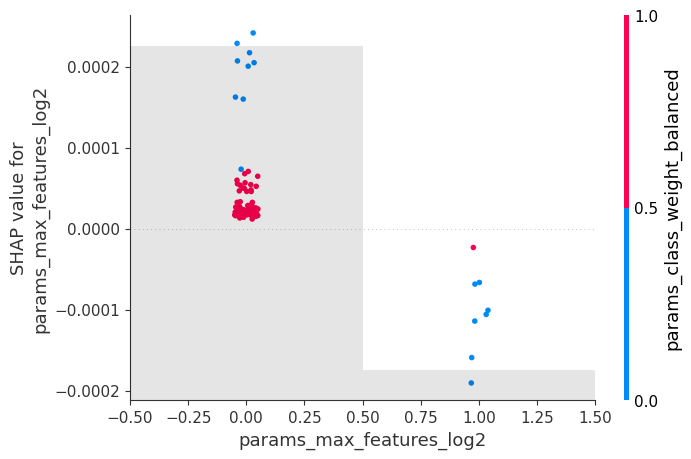

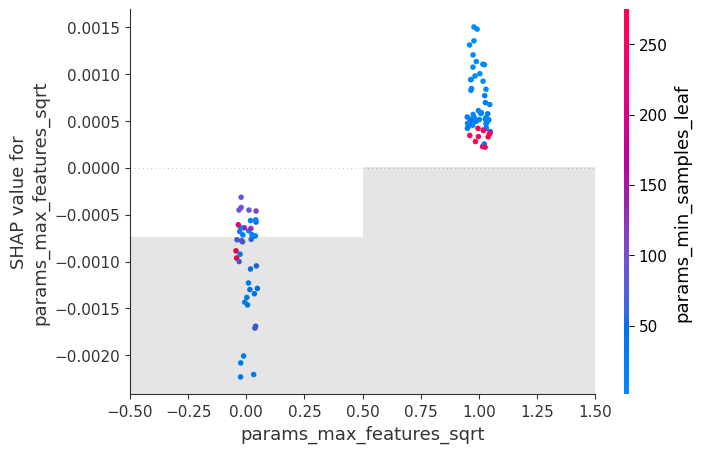

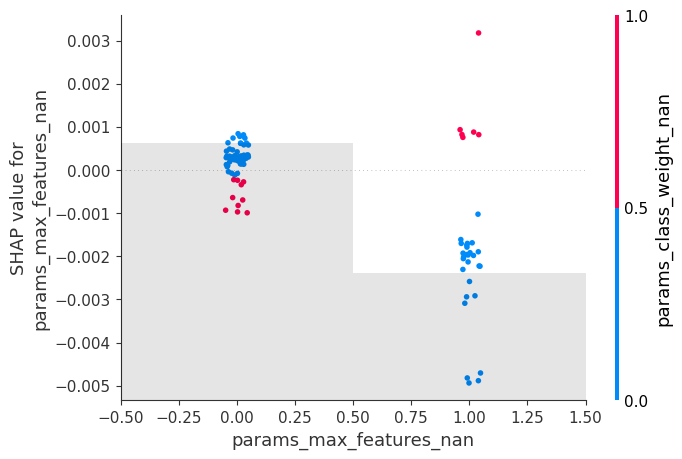

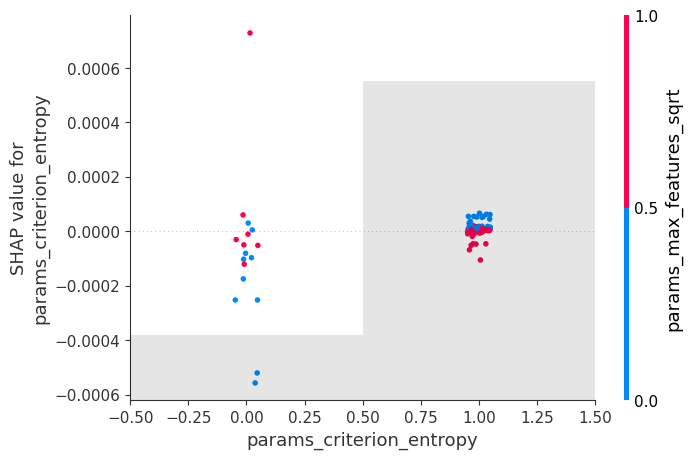

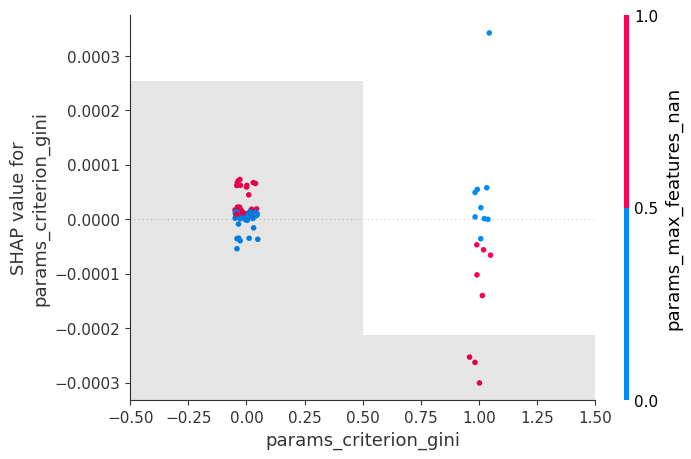

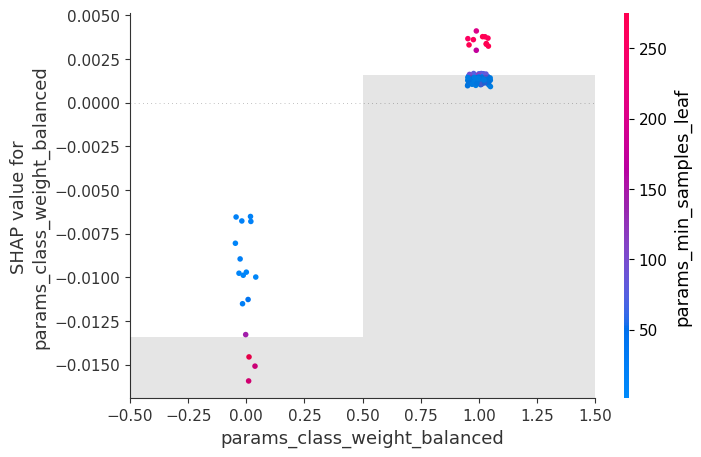

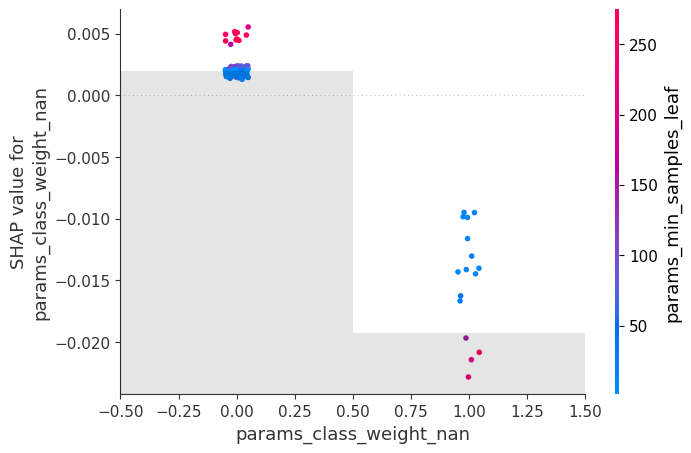

In [48]:
feature_names = list(X_test.columns)

for i, column in enumerate(X_test.columns):
    shap.plots.scatter(shap_values[:, feature_names.index(column)], color=shap_values)
    

Analyzing the charts we can see that most instances have hyperparameters with values (in range):
* n_estimators: 4000 - 5000
* max_depth: 400 - 700
* min_samples_split: 0 - 200
* min_samples_leaf: 0 - 50
* criterion = 'entropy'
* class_weight = 'balanced'

The less instances have:
* max_features = 'log2'

In [12]:
best_params_df = load_results('random_forest_adult_best_params', directory='optuna_results')
best_params_df.columns = ['params_' + col for col in best_params_df.columns]

In [13]:
best_params_index = X_shap[
    (X_shap["params_n_estimators"] == best_params_df["params_n_estimators"].values[0]) &
    (X_shap["params_max_depth"] == best_params_df["params_max_depth"].values[0]) &
    (X_shap["params_max_features"] == best_params_df["params_max_features"].values[0]) &
    (X_shap["params_min_samples_leaf"] == best_params_df["params_min_samples_leaf"].values[0]) &
    (X_shap["params_min_samples_split"] == best_params_df["params_min_samples_split"].values[0]) &
    (X_shap["params_criterion"] == best_params_df["params_criterion"].values[0]) &
    (X_shap["params_class_weight"] == best_params_df["params_class_weight"].values[0])
].index[0]

In [31]:
best_params_record_encoded = X_shap_encoded.loc[best_params_index]

In [32]:
shap_values_for_best_record = explainer(best_params_record_encoded.to_frame().T)

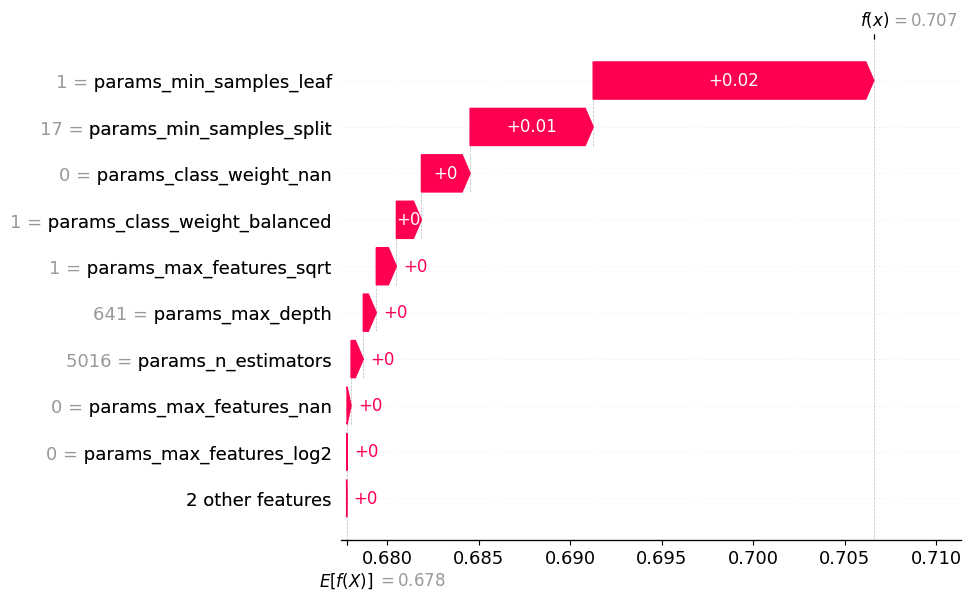

In [35]:
shap.plots.waterfall(shap_values_for_best_record[0])

##### XGBRegressor

In [12]:
def objective_random_forest_adult_xgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_int("gamma", 0, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    
    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        n_estimators=n_estimators,
        subsample=subsample,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        n_jobs=10
    )
    
    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=10
    ).mean()
    
    return score

In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest_adult_xgb, n_trials=200, n_jobs=10)

[I 2025-01-09 17:19:41,204] A new study created in memory with name: no-name-7397ce16-d772-4a9b-8757-4f7a1c5cc947
[I 2025-01-09 17:19:42,334] Trial 1 finished with value: 0.016672790377141786 and parameters: {'learning_rate': 0.0729112033940553, 'max_depth': 86, 'min_child_weight': 5, 'gamma': 2, 'n_estimators': 76, 'subsample': 0.7439640098714244}. Best is trial 1 with value: 0.016672790377141786.
[I 2025-01-09 17:19:43,841] Trial 2 finished with value: 0.016717220965406784 and parameters: {'learning_rate': 0.054352110856045605, 'max_depth': 53, 'min_child_weight': 1, 'gamma': 10, 'n_estimators': 72, 'subsample': 0.6724016550767009}. Best is trial 1 with value: 0.016672790377141786.
[I 2025-01-09 17:19:47,379] Trial 0 finished with value: 0.0021761420691965654 and parameters: {'learning_rate': 0.095306437484261, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0, 'n_estimators': 393, 'subsample': 0.5404220252292199}. Best is trial 0 with value: 0.0021761420691965654.
[I 2025-01-09 17:1

In [14]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.0017575396978065626
Params: {'learning_rate': 0.14118738007830714, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0, 'n_estimators': 698, 'subsample': 0.7967266258810052}


In [15]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='xgb_best_params', directory='random_forest_adult_models')

In [22]:
best_params_df = load_results(filename='xgb_best_params', directory='random_forest_adult_models')

In [23]:
model = xgb.XGBRegressor(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_child_weight=int(best_params_df['min_child_weight'].iloc[0]),
    gamma=float(best_params_df['gamma'].iloc[0]),
    subsample=float(best_params_df['subsample'].iloc[0]),
    learning_rate=float(best_params_df['learning_rate'].iloc[0]),
    n_jobs=10
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1411873800783071,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=698, n_jobs=10,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

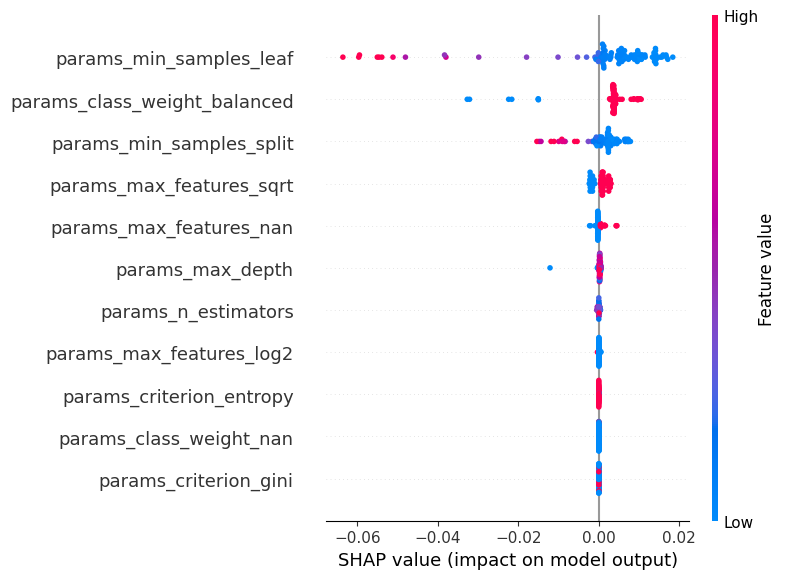

In [25]:
shap.summary_plot(shap_values, X_test)

Better performance can be achieved when:
* *min_samples_leaf* has lower values 
* *class_weight* equals 'balanced'
* *min_samples_split* has lower values 
* *max_features* value equals 'sqrt'

Again, most instances instances have SHAP values greater than or equal to 0.


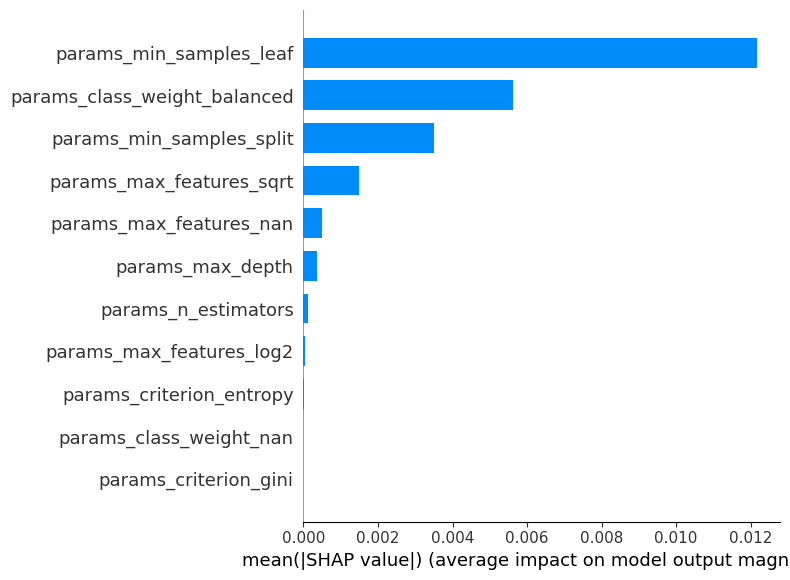

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* min_samples_leaf
* class_weight = 'balanced'
* min_samples_split

Least important features: 
* criterion
* class weight = None
* max_features = 'log2'
* n_estimators

##### MLPRegressor

In [39]:
def objective_random_forest_adult_mlp(trial):
    
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(25,), (50,), (100,), (50, 25), (100, 50)]
    )
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.0001, 0.001)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    alpha = trial.suggest_float("alpha", 0.0001, 0.01)
    max_iter = trial.suggest_int("max_iter", 500, 2000)

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        solver=solver,
        learning_rate_init=learning_rate_init,
        batch_size=batch_size,
        alpha=alpha,
        max_iter=max_iter
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=10
    ).mean()

    return score

In [40]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest_adult_mlp, n_trials=200, n_jobs=10)

[I 2025-01-09 20:02:26,696] A new study created in memory with name: no-name-d818a090-6efa-4bab-b354-093d8a0318bd
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (25,) which is of type tuple.
  warnings.warn(message)
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(mes

In [41]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.13679298752915378
Params: {'hidden_layer_sizes': (50, 25), 'solver': 'lbfgs', 'learning_rate_init': 0.00026043986741217443, 'batch_size': 64, 'alpha': 0.0006820933299027283, 'max_iter': 1915}


In [42]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='mlp_best_params', directory='random_forest_adult_models')

In [47]:
best_params_df = load_results(filename='mlp_best_params', directory='random_forest_adult_models')

In [48]:
model = MLPRegressor(
    hidden_layer_sizes=eval(best_params_df['hidden_layer_sizes'].iloc[0]),
    solver=best_params_df['solver'].iloc[0],
    learning_rate_init=float(best_params_df['learning_rate_init'].iloc[0]),
    batch_size=int(best_params_df['batch_size'].iloc[0]),
    alpha=float(best_params_df['alpha'].iloc[0]),
    max_iter=int(best_params_df['max_iter'].iloc[0])
)

model.fit(X_train, y_train)

MLPRegressor(alpha=0.0006820933299027, batch_size=64,
             hidden_layer_sizes=(50, 25), learning_rate_init=0.0002604398674121,
             max_iter=1915, solver='lbfgs')

In [50]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

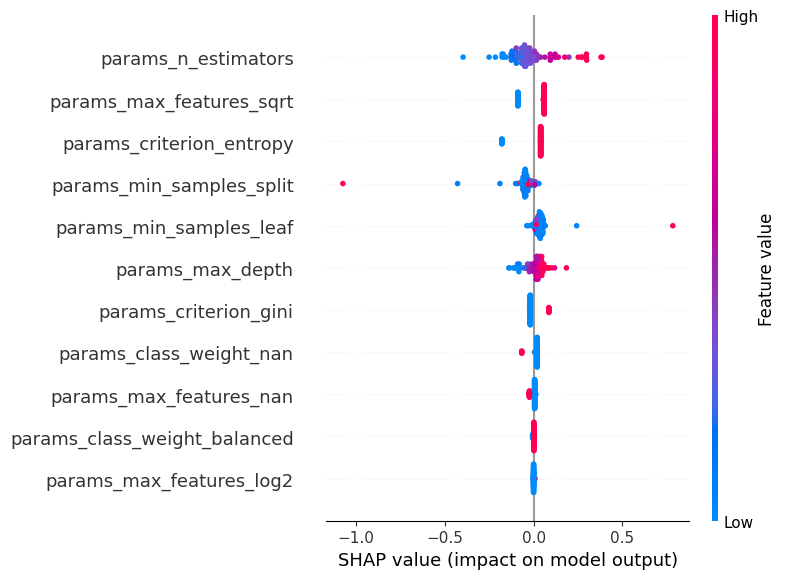

In [51]:
shap.summary_plot(shap_values, X_test)

Better performance can be achieved when:
* *n_estimators* has higher values
* *max_features* value equals 'sqrt'
* *criterion* equals 'gini' or 'entropy', Optuna chose 'entropy' more frequently
* *min_samples_leaf* has lower values 
* *max_depth* has higher values

Negative impact on the model output have:
* low values of *n_estimators*
* low values of *min_samples_split*
* class_weight = 'None'

It is interesting that there are more instances with negative SHAP values than positive ones for the most imporant hypeparameters (e. g. n_estimators). This may be due to the fact that this model has a higher MEA than others.

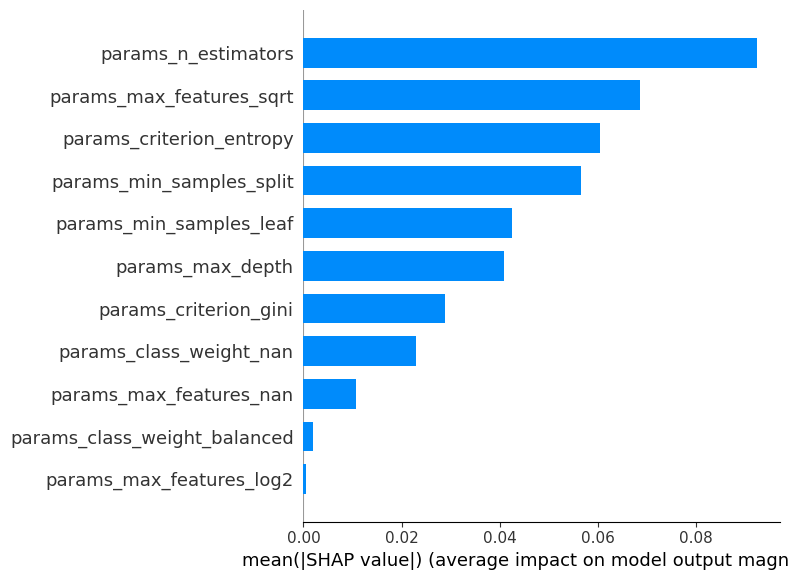

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* n_estimators
* max_features = 'sqrt'
* criterion = 'entropy'
* min_samples_split

Least important features: 
* max_features = 'log2'
* class weight = 'balanced'
* max_features = 'None'

##### **Summary**

Comparing shapley values that base on RandomForest and XGBoost regressors, whose performance is much the same, we got similiar explanations and parameter importances. The most important hyperparameters are: *min_samples_leaf*, *class_weight*, *min_samples_split* and the least important is e. g. *criterion* or *n_estimators*. The results are consistent with those obtained from Optuna.

However MLPRegressor gives us completely different results, where the *n_estimators* is the crucial one. This may be due to lower model performance.

#### **XGBRegressor optimization performed on the California dataset**


In [4]:
X, y = shap.datasets.california()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
parameters = [
    "n_estimators",
    "max_depth",
    "learning_rate",
    "min_child_weight",
    "gamma",
    "subsample",
    "lambda",
    "alpha",
    "colsample_bytree",
    "colsample_bylevel",
    "colsample_bynode"
]

In [10]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 5000)
    max_depth = trial.suggest_int("max_depth", 3, 100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.4)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 100)
    gamma = trial.suggest_float("gamma", 0, 50)
    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    lambda_param = trial.suggest_float("lambda", 1, 100)
    alpha = trial.suggest_float("alpha", 0, 100)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 1.0)
    colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.2, 1.0)
    colsample_bynode = trial.suggest_float("colsample_bynode", 0.2, 1.0)
    
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        lambda_=lambda_param,
        alpha=alpha,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        colsample_bynode=colsample_bynode,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        n_jobs=14
    )
    
    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()
    
    return score

In [11]:
study = optuna.create_study(direction="minimize")

[I 2025-01-10 22:35:12,287] A new study created in memory with name: no-name-9c9d6fa4-5a5a-48bc-810a-f4b1b65e6aeb


In [12]:
study.optimize(objective_xgb, n_trials=500, n_jobs=14)

[I 2025-01-10 22:35:47,740] Trial 3 finished with value: 0.4771602883979123 and parameters: {'n_estimators': 1190, 'max_depth': 69, 'learning_rate': 0.3635426189013701, 'min_child_weight': 77, 'gamma': 17.894825357395533, 'subsample': 0.7203922652045665, 'lambda': 34.25637782464009, 'alpha': 88.86284769266807, 'colsample_bytree': 0.4166676078414184, 'colsample_bylevel': 0.36927677386497965, 'colsample_bynode': 0.799321368033082}. Best is trial 3 with value: 0.4771602883979123.
[I 2025-01-10 22:36:46,449] Trial 8 finished with value: 0.4765979304042643 and parameters: {'n_estimators': 2429, 'max_depth': 98, 'learning_rate': 0.24276504310231944, 'min_child_weight': 91, 'gamma': 41.99914584537587, 'subsample': 0.7717892660138133, 'lambda': 82.59391387284397, 'alpha': 31.239682206972287, 'colsample_bytree': 0.8883861337765138, 'colsample_bylevel': 0.2265760716300097, 'colsample_bynode': 0.5364634496566203}. Best is trial 8 with value: 0.4765979304042643.
[I 2025-01-10 22:37:07,888] Trial 2

In [13]:
print("Best hyperparameters:", study.best_params)
print(f"Value: {study.best_value}")

Best hyperparameters: {'n_estimators': 4217, 'max_depth': 89, 'learning_rate': 0.13303506238546675, 'min_child_weight': 46, 'gamma': 0.039172933097113824, 'subsample': 0.8605930456755688, 'lambda': 1.15374029356788, 'alpha': 9.887141096143289, 'colsample_bytree': 0.9726273344018967, 'colsample_bylevel': 0.9301323613912363, 'colsample_bynode': 0.3449671745393691}
Value: 0.3120045367219813


In [14]:
results_df = study.trials_dataframe()

In [15]:
save_results(results_df, 'xgb_california')

In [16]:
best_params_df = pd.DataFrame([study.best_params])

In [17]:
save_results(best_params_df, filename='xgb_california_best_params', directory="optuna_results")

In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
optuna.visualization.plot_edf(study)

In [29]:
optuna.visualization.plot_param_importances(study)

In [30]:
for param in parameters:
    fig = optuna.visualization.plot_slice(study, params=[param])
    fig.update_layout(
        title=f"Slice Plot for {param}",
        yaxis_title="Objective Value",
        xaxis_title=param
    )

    pio.show(fig)

#### **Shap values - XGBRegressor optimization on the California dataset**
As above, we take 3 models to approximate hyperparameter impact. 
* RandomForestRegressor
* XGBoostRegressor
* MLPRegressor

Models are trained on the output from optimization process on California dataset. They are tuned with Optuna as well.

In [19]:
results_df = load_results('xgb_california')

In [20]:
X_shap = results_df[[  
    "params_n_estimators", 
    "params_max_depth", 
    "params_learning_rate", 
    "params_min_child_weight", 
    "params_gamma", 
    "params_subsample", 
    "params_lambda", 
    "params_alpha", 
    "params_colsample_bytree", 
    "params_colsample_bylevel", 
    "params_colsample_bynode"
]]

y_shap = results_df["value"]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_shap, y_shap, test_size=0.2)

##### RandomForestRegressor

In [22]:
def objective_xgb_california_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 100)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        bootstrap=bootstrap,
        n_jobs=14
    )
    
    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()
    
    return score

In [23]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb_california_random_forest, n_trials=200, n_jobs=14)

[I 2025-01-11 13:04:04,563] A new study created in memory with name: no-name-fb58045f-ba92-4655-bc6d-eee6952a2d24
[I 2025-01-11 13:04:06,513] Trial 3 finished with value: 0.009101763603727607 and parameters: {'n_estimators': 451, 'max_depth': 32, 'max_features': 0.6776610786655028, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False}. Best is trial 3 with value: 0.009101763603727607.
[I 2025-01-11 13:04:06,740] Trial 12 finished with value: 0.012067006021504493 and parameters: {'n_estimators': 82, 'max_depth': 82, 'max_features': 0.8747686874864191, 'min_samples_leaf': 19, 'min_samples_split': 20, 'bootstrap': False}. Best is trial 3 with value: 0.009101763603727607.
[I 2025-01-11 13:04:06,740] Trial 1 finished with value: 0.0104706449461383 and parameters: {'n_estimators': 253, 'max_depth': 73, 'max_features': 0.5305127939222999, 'min_samples_leaf': 8, 'min_samples_split': 11, 'bootstrap': False}. Best is trial 3 with value: 0.009101763603727607.
[I 2025-01-11 13:04:06,

In [24]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.008542178450529271
Params: {'n_estimators': 796, 'max_depth': 62, 'max_features': 0.7814424287826952, 'min_samples_leaf': 1, 'min_samples_split': 2, 'bootstrap': True}


In [25]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='random_forest_best_params', directory='xgb_california_models')

In [26]:
best_params_df = load_results(filename='random_forest_best_params', directory='xgb_california_models')

In [27]:
model = RandomForestRegressor(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    bootstrap=bool(best_params_df['bootstrap'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0]
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=62, max_features=0.7814424287826952,
                      n_estimators=796)

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

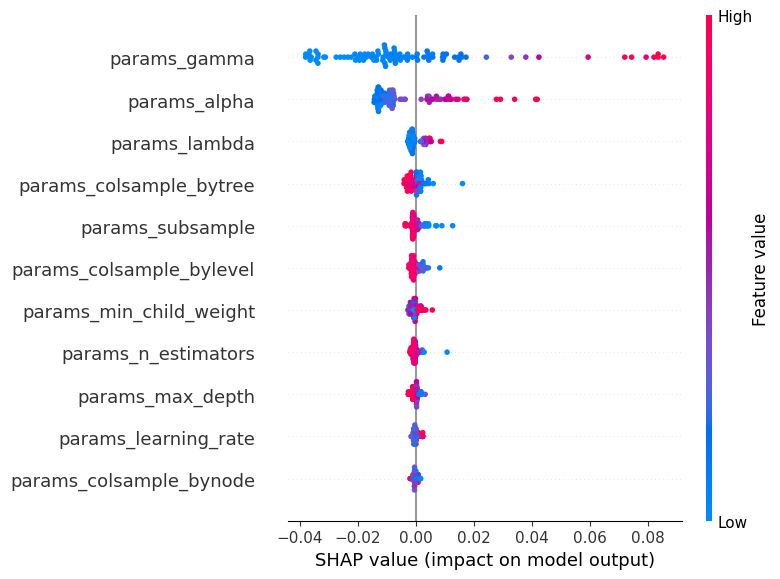

In [29]:
shap.summary_plot(shap_values, X_test)

Better performance can be achieved when:
* *alpha* value is high
* *lamda* value is high
* *colsample_bytree* value is low
* *colsample_bylevel* value is low
* *subsample* value is low 

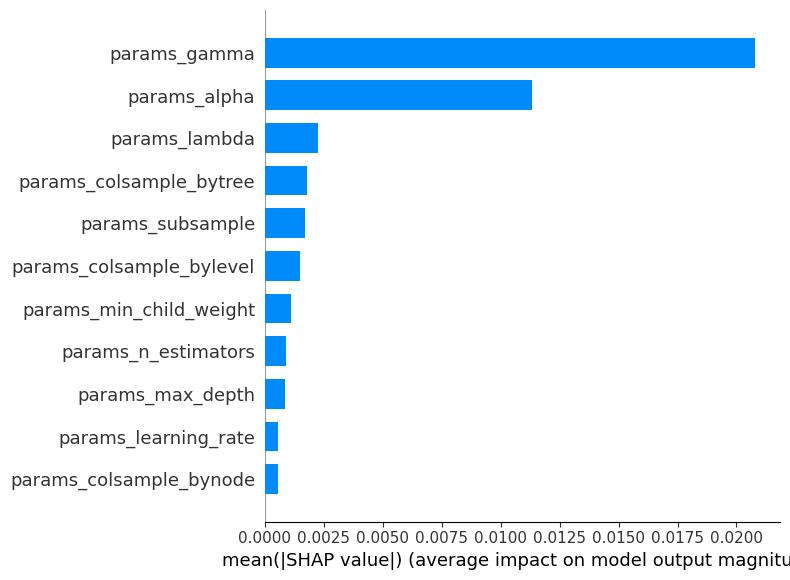

In [30]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* gamma
* alpha

Least important features: 
* colsample_bynode
* learning_rate

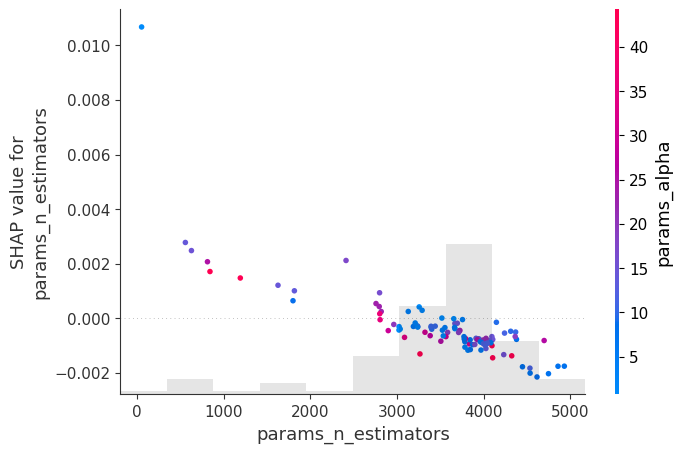

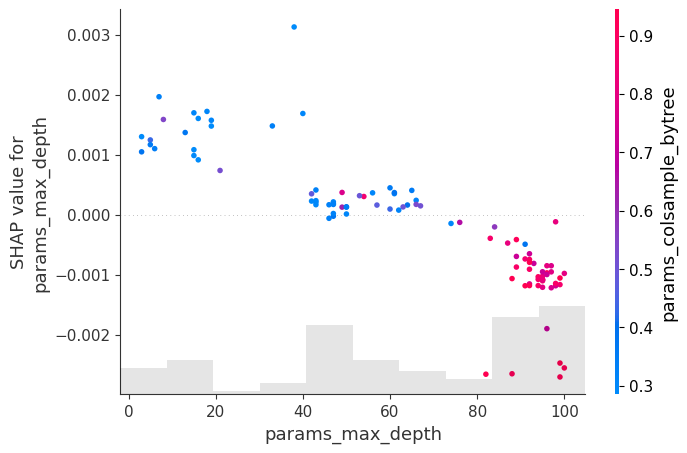

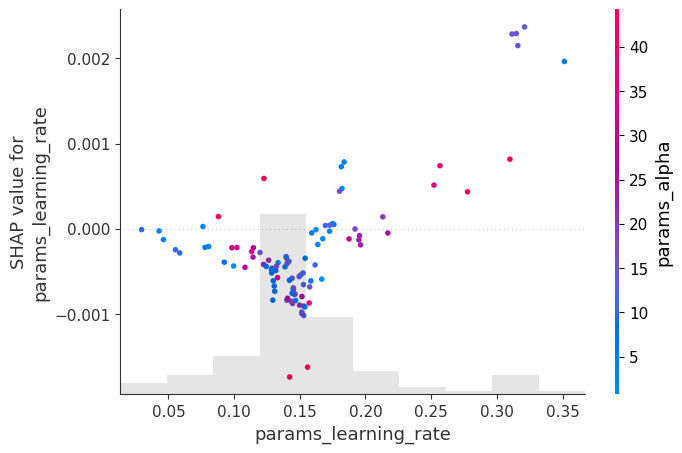

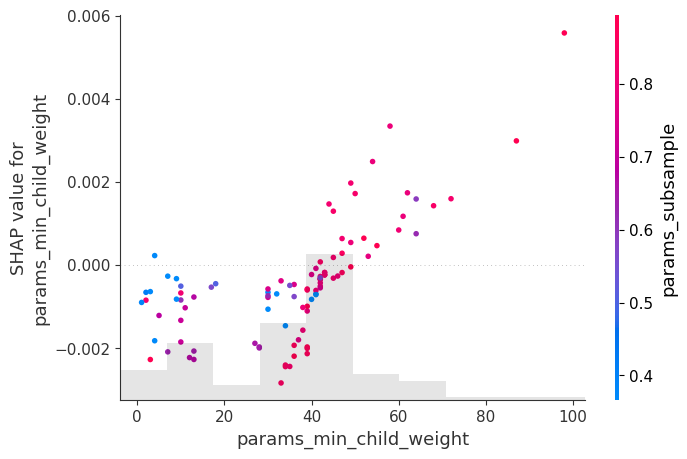

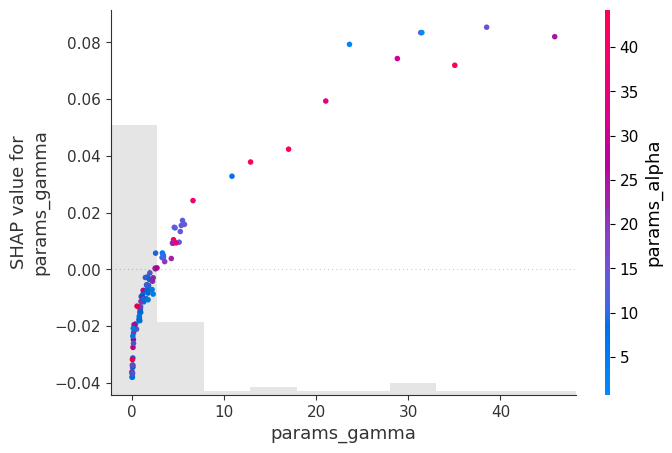

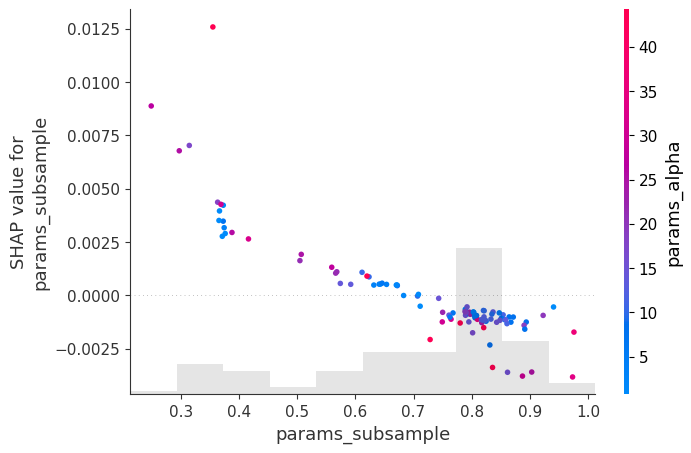

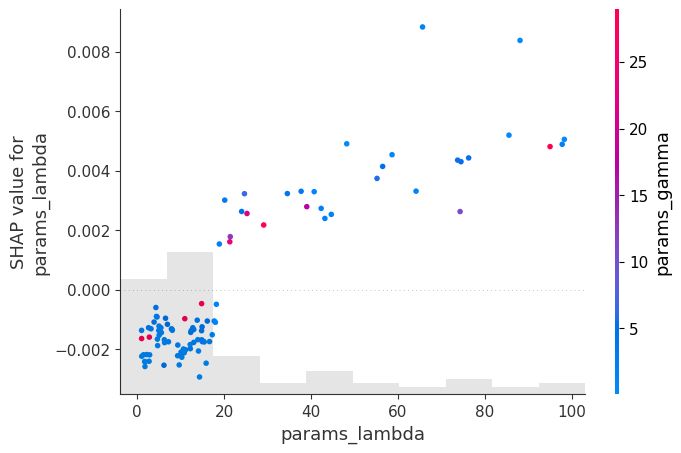

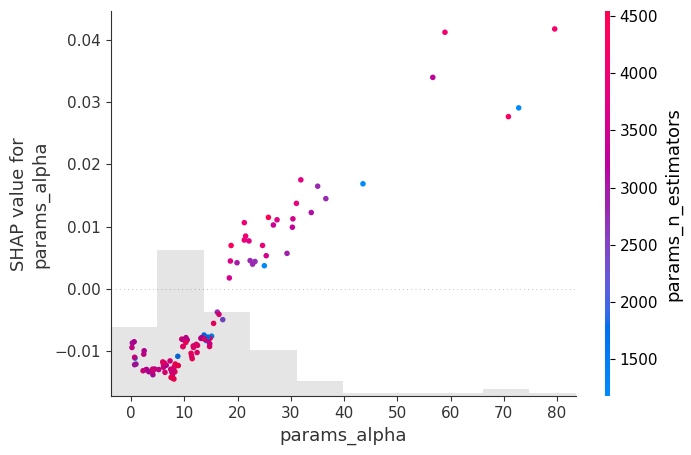

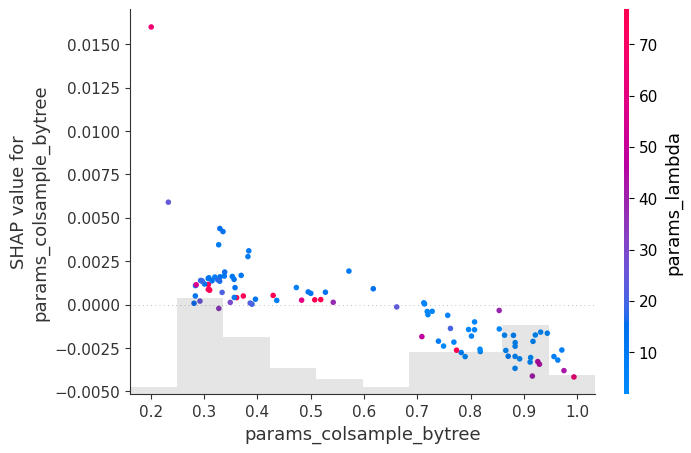

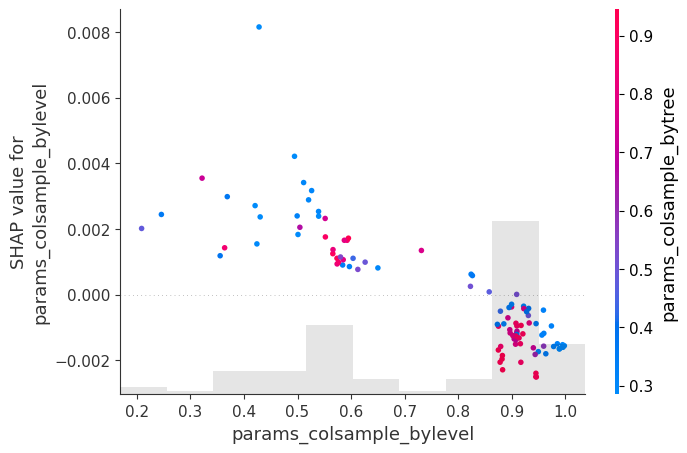

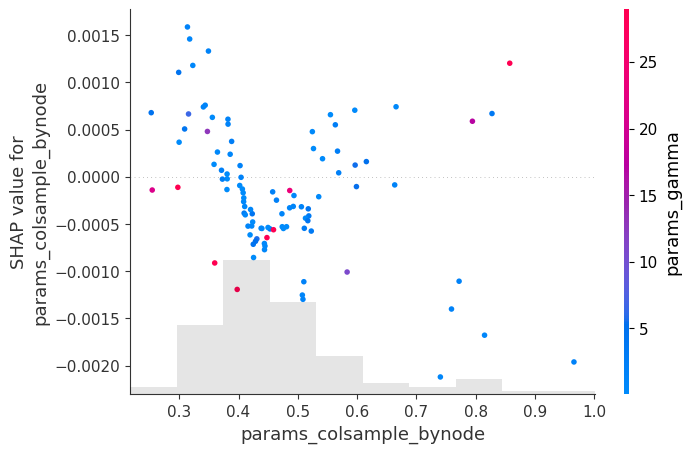

In [31]:
feature_names = list(X_test.columns)

for i, column in enumerate(X_test.columns):
    shap.plots.scatter(shap_values[:, feature_names.index(column)], color=shap_values)
    

Analyzing the charts we can see that most instances have negative impact.
Values of hyperparameters Optuna chose more frequently:
* n_estimators: 3000 - 4000 
* max_depth: 40 - 60 and 90 - 100
* learning_rate: 0.10-0.15 
* min_child_weight: 30 - 50
* gamma: 0 - 5 
* subsample: 0.8 - 0.9
* lambda: 0 - 20
* alpha: 0 - 10
* colsample_bytree: 0.3 - 0.4 and 0.8 - 0.9
* colsample_bylevel: 0.9 - 1.0

Hyperparameters with the following values ​​have a positive impact:
* n_estimators: < 3000
* max_depth: < 70
* min_child_weight: > 50
* gamma: >= 5 
* subsample: < 0.7
* lambda: > 20
* alpha: > 20
* colsample_bytree: < 0.6
* colsample_bylevel: <= 0.8

In [34]:
best_params_df = load_results('xgb_california_best_params', directory='optuna_results')
best_params_df.columns = ['params_' + col for col in best_params_df.columns]

In [36]:
shap_values_for_best_record = explainer(best_params_df)

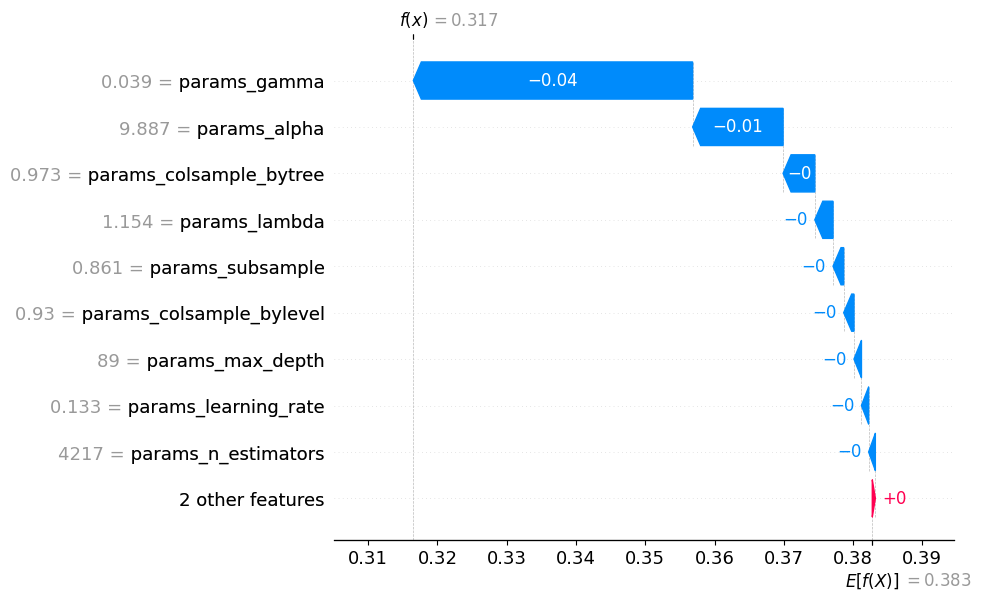

In [37]:
shap.plots.waterfall(shap_values_for_best_record[0])

##### XGBoostRegressor

In [39]:
def objective_xgb_california_xgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_int("gamma", 0, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    
    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        n_estimators=n_estimators,
        subsample=subsample,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        n_jobs=14
    )
    
    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()
    
    return score

In [40]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb_california_xgb, n_trials=200, n_jobs=14)

[I 2025-01-11 13:18:19,809] A new study created in memory with name: no-name-6eeff5cb-2a59-4ed1-ab35-52ed0361734c
[I 2025-01-11 13:18:31,206] Trial 0 finished with value: 0.03356826662944204 and parameters: {'learning_rate': 0.10297004261459092, 'max_depth': 30, 'min_child_weight': 4, 'gamma': 4, 'n_estimators': 679, 'subsample': 0.8200010241089626}. Best is trial 0 with value: 0.03356826662944204.
[I 2025-01-11 13:18:45,728] Trial 9 finished with value: 0.03357896169274474 and parameters: {'learning_rate': 0.08859047303720818, 'max_depth': 44, 'min_child_weight': 9, 'gamma': 6, 'n_estimators': 698, 'subsample': 0.7715263139027766}. Best is trial 0 with value: 0.03356826662944204.
[I 2025-01-11 13:18:48,735] Trial 13 finished with value: 0.033595585288956786 and parameters: {'learning_rate': 0.11397581536963106, 'max_depth': 92, 'min_child_weight': 10, 'gamma': 4, 'n_estimators': 223, 'subsample': 0.9504549995931492}. Best is trial 0 with value: 0.03356826662944204.
[I 2025-01-11 13:18

In [41]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.007030875950353617
Params: {'learning_rate': 0.02312213958585093, 'max_depth': 32, 'min_child_weight': 6, 'gamma': 0, 'n_estimators': 462, 'subsample': 0.6875720033014668}


In [42]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='xgb_best_params', directory='xgb_california_models')

In [43]:
best_params_df = load_results(filename='xgb_best_params', directory='xgb_california_models')

In [44]:
model = xgb.XGBRegressor(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_child_weight=int(best_params_df['min_child_weight'].iloc[0]),
    gamma=float(best_params_df['gamma'].iloc[0]),
    subsample=float(best_params_df['subsample'].iloc[0]),
    learning_rate=float(best_params_df['learning_rate'].iloc[0]),
    n_jobs=10
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0231221395858509,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=462, n_jobs=10,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

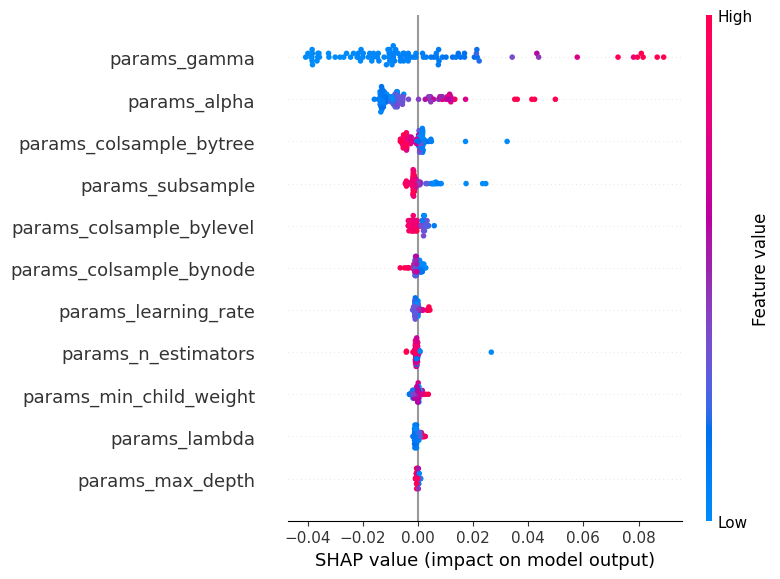

In [46]:
shap.summary_plot(shap_values, X_test)

Better performance can be achieved when:
* *alpha* has medium/high values
* *colsample_bytree* has low values
* *subsample* has low values
* *colsample_bylevel* - medium/low values
* *learning_rate* has high values

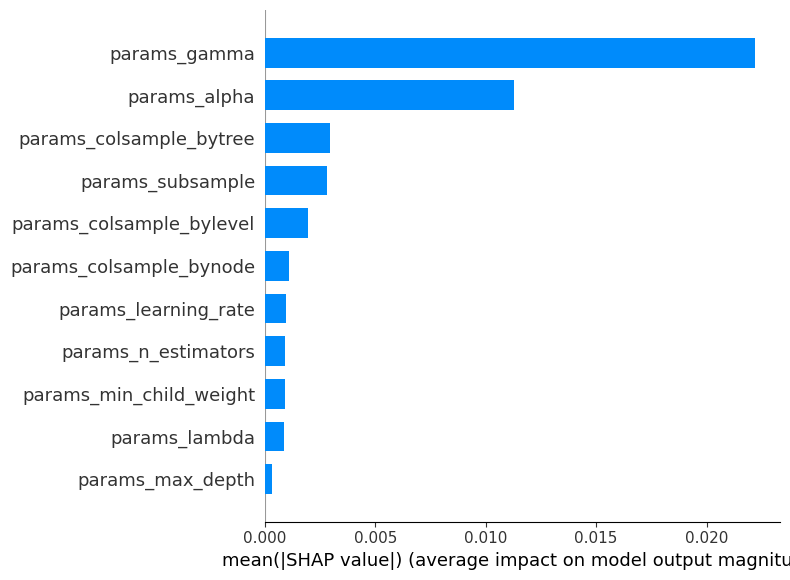

In [47]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* gamma
* alpha

Least important features: 
* max_depth
* lambda
* min_child_weight
* n_estimators
* learning_rate

##### MLPRegressor

In [49]:
def objective_xgb_california_mlp(trial):
    
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(25,), (50,), (100,), (50, 25), (100, 50)]
    )
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.0001, 0.001)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    alpha = trial.suggest_float("alpha", 0.0001, 0.01)
    max_iter = trial.suggest_int("max_iter", 500, 2000)

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        solver=solver,
        learning_rate_init=learning_rate_init,
        batch_size=batch_size,
        alpha=alpha,
        max_iter=max_iter
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()

    return score

In [50]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb_california_mlp, n_trials=200, n_jobs=14)

[I 2025-01-11 13:38:47,031] A new study created in memory with name: no-name-9e76ef81-0b7c-4387-9de3-6ac0c34350d6
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 25) which is of type tuple.
  warnings.warn(message)
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (25,) which is of type tuple.
  warnings.warn(message)
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50) which is of type tuple.
  warnings.wa

In [51]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.04441064115907192
Params: {'hidden_layer_sizes': (25,), 'solver': 'lbfgs', 'learning_rate_init': 0.0009227468266574, 'batch_size': 16, 'alpha': 0.0012835898782810216, 'max_iter': 1423}


In [52]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='mlp_best_params', directory='xgb_california_models')

In [53]:
best_params_df = load_results(filename='mlp_best_params', directory='xgb_california_models')

In [54]:
model = MLPRegressor(
    hidden_layer_sizes=eval(best_params_df['hidden_layer_sizes'].iloc[0]),
    solver=best_params_df['solver'].iloc[0],
    learning_rate_init=float(best_params_df['learning_rate_init'].iloc[0]),
    batch_size=int(best_params_df['batch_size'].iloc[0]),
    alpha=float(best_params_df['alpha'].iloc[0]),
    max_iter=int(best_params_df['max_iter'].iloc[0])
)

model.fit(X_train, y_train)

MLPRegressor(alpha=0.001283589878281, batch_size=16, hidden_layer_sizes=(25,),
             learning_rate_init=0.0009227468266574, max_iter=1423,
             solver='lbfgs')

In [55]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

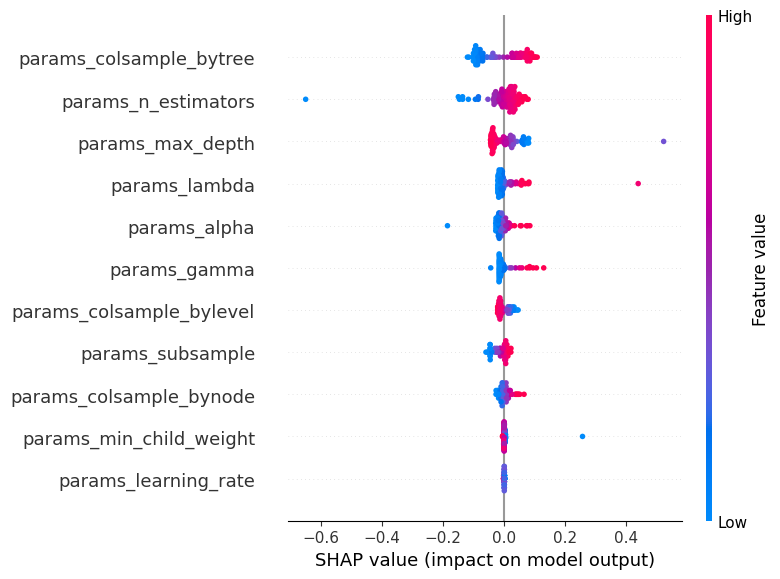

In [56]:
shap.summary_plot(shap_values, X_test)

Analyzing the graph we can conclude that the higher the values of hyperparameters: *colsample_bytree*, *n_estimators*, *lambda*, *alpha*, *gamma*, *colsample_bynode*, *subsample*, the more positive impact they have on the model output and the higher the values of: *max_depth*, *colsample_bylevel*, the more negative the impact.

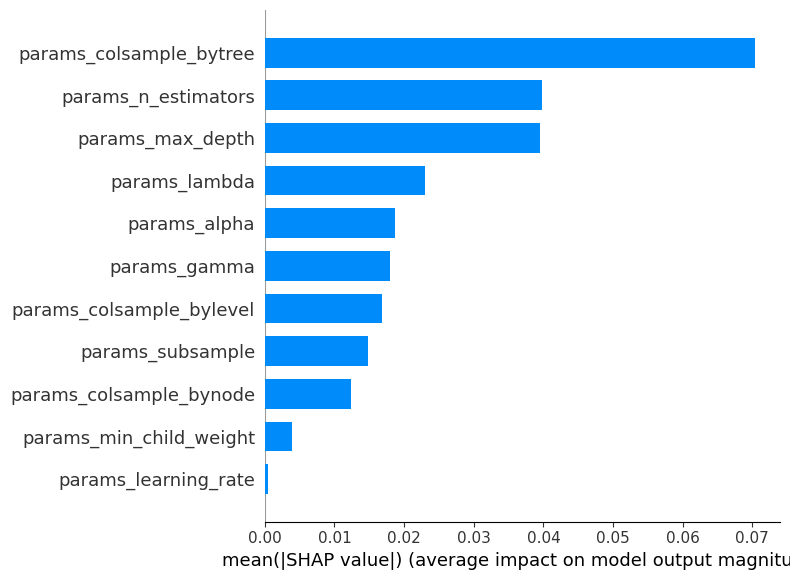

In [57]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* colsample_bytree
* n_estimators
* max_depth

Least important features: 
* learning_rate
* min_child_weight

##### **Summary**

From RandomForest and XGBoost resressors we received similiar results again. Top 2 most important parameters are the same: *gamma*, *alpha* but there are differences in the least important ones. When comparing the feature importances obtained in the optimization process, the regressors did not focus on the hyperparameter *subsample* that, according to Optuna, was the second crucial one. 
The MLPRegressor again gave us different results where the colsample_bytree is the key parameter. 
According to all models, *learning_rate* is one of the least important features. 